In [1]:
%pip install sas-pip/

Processing ./sas-pip
  Preparing metadata (setup.py) ... done
  Created wheel for sas: filename=sas-1.0-py3-none-any.whl size=6290 sha256=8e114bf90ca34f76d0ffd81d4d69c1ff13004fde4d2c701c7ec582272a65d390
  Stored in directory: /Users/jefferyqin/Library/Caches/pip/wheels/c3/c7/80/251166f03cb55d2fafc1a4fe53bdfe5780e3347b9f032879b9
Successfully built sas
  Attempting uninstall: sas
    Found existing installation: sas 1.0
    Uninstalling sas-1.0:
      Successfully uninstalled sas-1.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/f_/04jbrhk575n06xwd88662jhw0000gn/T/pip-req-build-mnzzjn43
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/f_/04jbrhk575n06xwd88662jhw0000gn/T/pip-req-build-mnzzjn43
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [4]:
import torchvision.transforms as transforms
mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
std = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)
transform_train = transforms.Compose([
        #transforms.ToPILImage(),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

In [5]:
import torchvision
from torchvision import transforms

cifar100 = torchvision.datasets.CIFAR100("./data/cifar100/", transform=transform_train,download=True)
device = "cuda:0"

Files already downloaded and verified


In [2]:
import torchvision
from torchvision import transforms

cifar100 = torchvision.datasets.CIFAR100("./data/cifar100/", transform=transforms.ToTensor(), download=True)
# device = "mps"
device = 'cuda:0'

Files already downloaded and verified


In [3]:
from sas.approx_latent_classes import clip_approx
from sas.subset_dataset import SASSubsetDataset
import random 

rand_labeled_examples_indices = random.sample(range(len(cifar100)), 500)
rand_labeled_examples_labels = [cifar100[i][1] for i in rand_labeled_examples_indices]

partition = clip_approx(
    img_trainset=cifar100,
    labeled_example_indices=rand_labeled_examples_indices, 
    labeled_examples_labels=rand_labeled_examples_labels,
    num_classes=100,
    device = device
)

In [5]:
from torch import nn 

class ProxyModel(nn.Module):
    def __init__(self, net, critic):
        super().__init__()
        self.net = net
        self.critic = critic
    def forward(self, x):
        return self.critic.project(self.net(x))

## balanced_cifar

In [13]:
from sas.approx_latent_classes import clip_approx
from sas.subset_dataset import SASSubsetDataset

In [14]:
from sklearn.model_selection import train_test_split

labels = [cifar100[i][1] for i in range(len(cifar100))]
indices = range(len(cifar100))
(
    cifar_balanced,
    _,
    labels_train,
    _,
    indices_train,
    _,
) = train_test_split(cifar100, labels, indices, test_size=0.5, stratify=labels)

In [35]:
cifar = cifar_balanced + cifar_balanced

In [36]:
len(cifar)

50000

In [39]:
import torch 

net = torch.load("proxy-cifar100-resnet10-399-net.pt", map_location=torch.device('mps'))
critic = torch.load("proxy-cifar100-resnet10-399-critic.pt", map_location=torch.device('mps'))
proxy_model = ProxyModel(net, critic)
device = "mps"
     
subset_dataset_balanced = SASSubsetDataset(
    dataset=cifar,
    subset_fraction=0.2,
    num_downstream_classes=100,
    device=device,
    proxy_model=proxy_model,
    approx_latent_class_partition=partition,
    verbose=True
)

Subset Selection:: 100%|████████████████████████| 99/99 [00:02<00:00, 38.59it/s]

Subset Size: 10000
Discarded 40000 examples


In [40]:
len(subset_dataset_balanced.subset_indices)

9961

In [42]:
count_balanced = {}
for x,y in subset_dataset_balanced:
    if y not in count_balanced:
        count_balanced[y] = 1
    else:
        count_balanced[y]+=1

Keys = list(count_balanced.keys())
Keys.sort()
sorted_dict_balanced = {i: count_balanced[i] for i in Keys}
print(sorted_dict_balanced)

{0: 14, 1: 162, 2: 111, 3: 93, 4: 211, 5: 36, 6: 92, 7: 87, 8: 47, 9: 48, 10: 47, 11: 63, 12: 96, 13: 34, 14: 167, 15: 81, 16: 48, 17: 20, 18: 198, 19: 125, 20: 10, 21: 98, 22: 20, 23: 70, 24: 37, 25: 88, 26: 118, 27: 267, 28: 87, 29: 76, 30: 161, 31: 98, 32: 148, 33: 105, 34: 151, 35: 64, 36: 68, 37: 48, 38: 182, 39: 16, 40: 132, 41: 64, 42: 126, 43: 117, 44: 174, 45: 121, 46: 105, 47: 15, 48: 19, 49: 66, 50: 212, 51: 121, 52: 16, 53: 13, 54: 82, 55: 208, 56: 34, 57: 60, 58: 28, 59: 42, 60: 44, 61: 7, 62: 50, 63: 223, 64: 177, 65: 225, 66: 144, 67: 222, 68: 44, 69: 166, 70: 58, 71: 97, 72: 163, 73: 169, 74: 249, 75: 83, 76: 116, 77: 198, 78: 131, 79: 204, 80: 262, 81: 25, 82: 30, 83: 36, 84: 69, 85: 84, 86: 33, 87: 58, 88: 121, 89: 62, 90: 64, 91: 122, 92: 58, 93: 174, 94: 17, 95: 108, 96: 51, 97: 152, 98: 89, 99: 129}


In [43]:
num_less50 = 0
num_bigger50 = 0

for i in Keys:
    if i < 50:
        num_less50 += count_balanced[i]
    else:
        num_bigger50 += count_balanced[i]
        
print(num_less50, num_bigger50)

4631 5330


## imbalanced_cifar

In [6]:
from collections import defaultdict, Counter
import numpy as np
import random

labels = [cifar100[i][1] for i in range(len(cifar100))]
indices = range(len(cifar100))

dic = defaultdict(list)
cifar_imbalanced = []

for i in range(len(cifar100)):
    label = cifar100[i][1]
    dic[label].append(i)

Keys = list(dic.keys())
Keys.sort()
sorted_dict = {i: len(dic[i]) for i in Keys}
print(sorted_dict)



{0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500, 9: 500, 10: 500, 11: 500, 12: 500, 13: 500, 14: 500, 15: 500, 16: 500, 17: 500, 18: 500, 19: 500, 20: 500, 21: 500, 22: 500, 23: 500, 24: 500, 25: 500, 26: 500, 27: 500, 28: 500, 29: 500, 30: 500, 31: 500, 32: 500, 33: 500, 34: 500, 35: 500, 36: 500, 37: 500, 38: 500, 39: 500, 40: 500, 41: 500, 42: 500, 43: 500, 44: 500, 45: 500, 46: 500, 47: 500, 48: 500, 49: 500, 50: 500, 51: 500, 52: 500, 53: 500, 54: 500, 55: 500, 56: 500, 57: 500, 58: 500, 59: 500, 60: 500, 61: 500, 62: 500, 63: 500, 64: 500, 65: 500, 66: 500, 67: 500, 68: 500, 69: 500, 70: 500, 71: 500, 72: 500, 73: 500, 74: 500, 75: 500, 76: 500, 77: 500, 78: 500, 79: 500, 80: 500, 81: 500, 82: 500, 83: 500, 84: 500, 85: 500, 86: 500, 87: 500, 88: 500, 89: 500, 90: 500, 91: 500, 92: 500, 93: 500, 94: 500, 95: 500, 96: 500, 97: 500, 98: 500, 99: 500}


In [7]:
selected_indices = []
for label in dic.keys():
    if label < 50:
        selected_indices += random.sample(dic[label], 50)
    else:
        selected_indices += random.sample(dic[label], 450)
        
random.shuffle(selected_indices)

cifar_imbalanced = []
for i in selected_indices:
    cifar_imbalanced.append(cifar100[i])

In [8]:
print(len(cifar_imbalanced))

25000


In [9]:
cifar_im = cifar_imbalanced + cifar_imbalanced
random.shuffle(cifar_im)

len(cifar_im)

50000

In [10]:
from train_changedata import main

best_acc, confusion_matrix = main(train_dataset= cifar_im)


{'net': 'vgg16', 'gpu': True, 'b': 100, 'warm': 1, 'lr': 0.1, 'resume': False}
train_data loader is ready
Files already downloaded and verified
test_data loader is ready
Training Epoch: 1 [50000/50000]	Loss: 3.6240	LR: 0.100000
epoch 1 training time consumed: 56.06s
GPU INFO.....
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 423551 KiB |   1441 MiB |   2778 GiB |   2778 GiB |
|       from large pool | 420160 KiB |   1386 MiB |   2765 GiB |   2765 GiB |
|       from sma

d:\anaconda\anaconda3\envs\260d\lib\site-packages\torch\optim\lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training Epoch: 2 [50000/50000]	Loss: 2.8368	LR: 0.100000
epoch 2 training time consumed: 49.41s
GPU INFO.....
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 423359 KiB |   1441 MiB |   3526 GiB |   3525 GiB |
|       from large pool | 419968 KiB |   1386 MiB |   3504 GiB |   3504 GiB |
|       from small pool |   3391 KiB |     58 MiB |     21 GiB |     21 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 42335

In [11]:
print(best_acc)
print(confusion_matrix)

tensor(0.1995, device='cuda:0')
[[ 7  0  0 ...  0  0  1]
 [ 0  4  0 ...  0  1  2]
 [ 0  0  0 ...  0 22  1]
 ...
 [ 0  0  0 ... 19  4  1]
 [ 0  0  0 ...  0 24  3]
 [ 0  0  0 ...  0  0 48]]


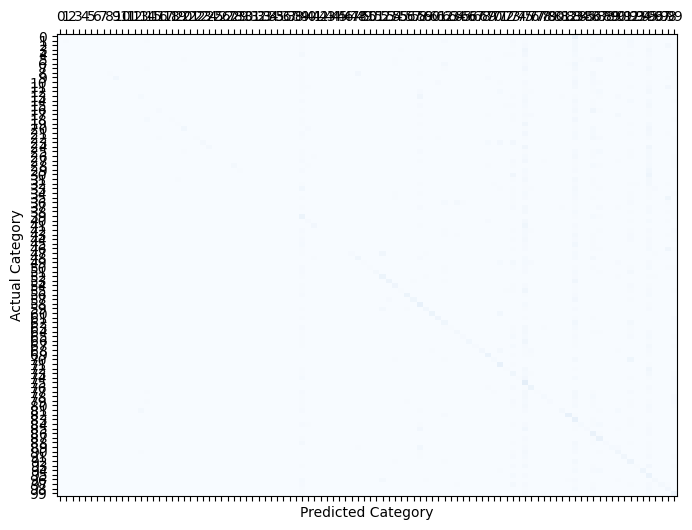

In [12]:
import matplotlib.pyplot as plt

classes = range(100)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(100), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(100), classes)
plt.show()

## imbalanced subset=0.2/0.8

In [13]:
import torch 

net = torch.load("proxy-cifar100-resnet10-399-net.pt", map_location=torch.device('cuda:0'))
critic = torch.load("proxy-cifar100-resnet10-399-critic.pt", map_location=torch.device('cuda:0'))
proxy_model = ProxyModel(net, critic)
# device = "mps"
device = 'cuda:0'
     
subset_dataset_imbalanced = SASSubsetDataset(
    dataset=cifar_im,
    subset_fraction=0.8,
    num_downstream_classes=100,
    device=device,
    proxy_model=proxy_model,
    approx_latent_class_partition=partition,
    verbose=True
)

Subset Selection:: 100%|██████████| 99/99 [00:03<00:00, 27.70it/s]

Subset Size: 40000
Discarded 10000 examples


In [14]:
len(subset_dataset_imbalanced.subset_indices)

39964

In [15]:
count_imbalanced = {}
for x,y in subset_dataset_imbalanced:
    if y not in count_imbalanced:
        count_imbalanced[y] = 1
    else:
        count_imbalanced[y]+=1

Keys = list(count_imbalanced.keys())
Keys.sort()
sorted_dict_imbalanced = {i: count_imbalanced[i] for i in Keys}
print(sorted_dict_imbalanced)

{0: 31, 1: 99, 2: 74, 3: 90, 4: 94, 5: 60, 6: 89, 7: 77, 8: 50, 9: 42, 10: 75, 11: 61, 12: 91, 13: 67, 14: 94, 15: 74, 16: 54, 17: 52, 18: 99, 19: 79, 20: 21, 21: 87, 22: 36, 23: 83, 24: 38, 25: 71, 26: 91, 27: 100, 28: 94, 29: 71, 30: 99, 31: 72, 32: 93, 33: 83, 34: 91, 35: 54, 36: 91, 37: 75, 38: 90, 39: 29, 40: 84, 41: 53, 42: 90, 43: 88, 44: 92, 45: 91, 46: 55, 47: 45, 48: 46, 49: 94, 50: 861, 51: 801, 52: 365, 53: 301, 54: 817, 55: 859, 56: 527, 57: 571, 58: 555, 59: 559, 60: 772, 61: 439, 62: 755, 63: 867, 64: 841, 65: 878, 66: 806, 67: 880, 68: 700, 69: 872, 70: 790, 71: 844, 72: 860, 73: 885, 74: 881, 75: 757, 76: 743, 77: 869, 78: 812, 79: 795, 80: 884, 81: 558, 82: 428, 83: 622, 84: 697, 85: 844, 86: 499, 87: 749, 88: 773, 89: 778, 90: 764, 91: 682, 92: 798, 93: 875, 94: 384, 95: 843, 96: 708, 97: 791, 98: 551, 99: 815}


In [16]:
num_less50 = 0
num_bigger50 = 0

for i in Keys:
    if i < 50:
        num_less50 += count_imbalanced[i]
    else:
        num_bigger50 += count_imbalanced[i]
        
print(num_less50, num_bigger50)

3659 36305


In [17]:
# sample_index = read_subset_dataset 
sample_index = subset_dataset_imbalanced.subset_indices
X_train = []
y_train = []
for i in sample_index:
    X = cifar_im[i][0]
    X_train.append(X)
    y = cifar_im[i][1]
    y_train.append(y)

im_subset_train_data = [(X, y) for X, y in zip(X_train, y_train)] #包装为数据对
# trainDataLoader = torch.utils.data.DataLoader(sampled_train_data, batch_size=16, shuffle=True)

In [18]:
less50 = 0
more50 = 0
for X,y in im_subset_train_data:
    if y<50:
        less50+=1
    else:
        more50+=1
print(less50,more50)

3659 36305


In [19]:
from train_changedata import main

# main(train_dataset= cifar100)
best_acc, confusion_matrix = main(train_dataset=im_subset_train_data)

{'net': 'vgg16', 'gpu': True, 'b': 100, 'warm': 1, 'lr': 0.1, 'resume': False}
train_data loader is ready
Files already downloaded and verified
test_data loader is ready
Training Epoch: 1 [39964/39964]	Loss: 4.0628	LR: 0.100000
epoch 1 training time consumed: 39.97s
GPU INFO.....
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 445478 KiB |   1441 MiB | 107539 GiB | 107538 GiB |
|       from large pool | 438912 KiB |   1386 MiB | 106258 GiB | 106257 GiB |
|       from smal

d:\anaconda\anaconda3\envs\260d\lib\site-packages\torch\optim\lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training Epoch: 2 [39964/39964]	Loss: 3.2601	LR: 0.100000
epoch 2 training time consumed: 39.13s
GPU INFO.....
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 445479 KiB |   1441 MiB | 108146 GiB | 108146 GiB |
|       from large pool | 438912 KiB |   1386 MiB | 106858 GiB | 106857 GiB |
|       from small pool |   6567 KiB |     58 MiB |   1288 GiB |   1288 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 44547

In [20]:
print(best_acc)
print(confusion_matrix)

tensor(0.1944, device='cuda:0')
[[ 1  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  1]
 [ 0  0  0 ...  0 17  3]
 ...
 [ 0  0  0 ...  9  3  7]
 [ 1  0  0 ...  0 32  4]
 [ 0  0  0 ...  0  0 55]]


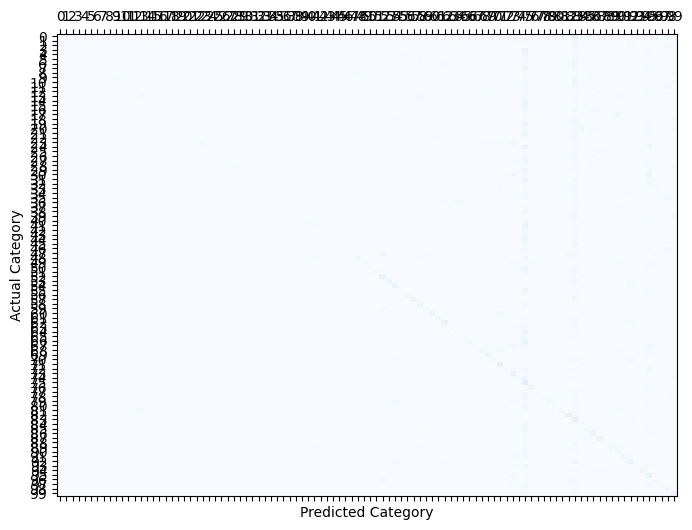

In [21]:
import matplotlib.pyplot as plt

classes = range(100)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(100), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(100), classes)
plt.show()

## Upsampling
we propose three solutions:
- copy and make the first 50 classes to have 500 data points for each class
- generalize the first solution to make the minority class(less than 500 data points) to resample to 500 points(general version of the first solution)
- use augmentation method to make the minority class have 500 augmentation data point

In [37]:
cifar_im_less50 = []
cifar_im_bigger50 = []

for x,y in cifar_im:
    if y < 50:
        cifar_im_less50.append((x,y))
    else:
        cifar_im_bigger50.append((x,y))

In [39]:
print(len(cifar_im_less50), len(cifar_im_bigger50))


5000 45000


In [40]:
from sklearn.utils import resample

cifar_im_less50 = resample(cifar_im_less50,
             replace=True,
             n_samples=25000,
             random_state=42)

cifar_im_bigger50 = resample(cifar_im_bigger50,
             replace=True,
             n_samples=25000,
             random_state=42)

In [41]:
print(len(cifar_im_less50), len(cifar_im_bigger50))

25000 25000


In [42]:
cifar_sampled = cifar_im_less50 + cifar_im_bigger50
random.shuffle(cifar_sampled)

In [43]:
import torch 

net = torch.load("proxy-cifar100-resnet10-399-net.pt", map_location=torch.device('mps'))
critic = torch.load("proxy-cifar100-resnet10-399-critic.pt", map_location=torch.device('mps'))
proxy_model = ProxyModel(net, critic)
device = "mps"
     
subset_dataset_sampled = SASSubsetDataset(
    dataset=cifar_sampled,
    subset_fraction=0.2,
    num_downstream_classes=100,
    device=device,
    proxy_model=proxy_model,
    approx_latent_class_partition=partition,
    verbose=True
)

Subset Selection:: 100%|██████████████████████| 100/100 [00:02<00:00, 37.20it/s]

Subset Size: 10000
Discarded 40000 examples


In [44]:
len(subset_dataset_sampled.subset_indices)

9959

In [45]:
count_sampled = {}
for x,y in subset_dataset_sampled:
    if y not in count_sampled:
        count_sampled[y] = 1
    else:
        count_sampled[y]+=1

Keys = list(count_sampled.keys())
Keys.sort()
sorted_dict_sampled = {i: count_sampled[i] for i in Keys}
print(sorted_dict_sampled)

{0: 12, 1: 173, 2: 131, 3: 106, 4: 205, 5: 38, 6: 86, 7: 73, 8: 83, 9: 48, 10: 62, 11: 94, 12: 94, 13: 27, 14: 188, 15: 94, 16: 21, 17: 14, 18: 205, 19: 124, 20: 18, 21: 65, 22: 45, 23: 54, 24: 47, 25: 80, 26: 105, 27: 282, 28: 89, 29: 59, 30: 178, 31: 117, 32: 160, 33: 73, 34: 153, 35: 72, 36: 107, 37: 39, 38: 226, 39: 9, 40: 141, 41: 58, 42: 97, 43: 117, 44: 210, 45: 114, 46: 98, 47: 21, 48: 34, 49: 54, 50: 217, 51: 97, 52: 20, 53: 15, 54: 71, 55: 197, 56: 32, 57: 64, 58: 35, 59: 39, 60: 36, 61: 20, 62: 58, 63: 182, 64: 184, 65: 231, 66: 173, 67: 187, 68: 55, 69: 166, 70: 55, 71: 101, 72: 136, 73: 157, 74: 234, 75: 72, 76: 108, 77: 169, 78: 120, 79: 210, 80: 197, 81: 34, 82: 25, 83: 31, 84: 64, 85: 99, 86: 33, 87: 49, 88: 121, 89: 61, 90: 62, 91: 160, 92: 61, 93: 158, 94: 14, 95: 126, 96: 69, 97: 135, 98: 87, 99: 132}


In [46]:
num_less50 = 0
num_bigger50 = 0

for i in Keys:
    if i < 50:
        num_less50 += count_sampled[i]
    else:
        num_bigger50 += count_sampled[i]
        
print(num_less50, num_bigger50)

4800 5159
